# Самостоятельный проект. 
## Тема принятие решений в бизнесе.

Проект разбит на две части, в первой необходимо выполнить приоритизацию гипотез, а во второй - анализ А/В теста.

# Часть 1. Приоритизация гипотез.

Приоритизацию гипотез будем выполнять фреймворками ICE и RICE. Так же проверим наличие изменений результатов в зависимости от выполняемого метода.

### Описание файла с данными по гипотезам:

- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

In [1]:
#Загрузим необходимые библиотеки.

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy import stats as st
import re
from datetime import datetime, timedelta
import datetime as dt

import scipy.stats as stats
import datetime as dt

In [2]:
#Загружаем все данные по работе с проектом

try:
    hypothesis = pd.read_csv('\\Users\\Home\\Documents\\Yandex\\2 модуль\\проект №3 Принятие решений в бизнесе\\hypothesis.csv') # Локальный путь
    orders = pd.read_csv('\\Users\\Home\\Documents\\Yandex\\2 модуль\\проект №3 Принятие решений в бизнесе\\orders.csv')
    visitors = pd.read_csv('\\Users\\Home\\Documents\\Yandex\\2 модуль\\проект №3 Принятие решений в бизнесе\\visitors.csv')

except:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv') # Серверный путь
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')


In [3]:
display(hypothesis.head())
display(orders.head())
display(visitors.head())

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


### Выполним проверку таблицы hypothesis на дубликаты и пропуски

In [4]:
# Напишем функцию для проверки наличия дубликатов и пропусков

def check_dup_nan(dataframe):
    df = dataframe
    list_col = list(df.columns)
    print('Количество задублированных строк в дата сете:', df.duplicated().sum(), 'шт.')
    print('')
    summa = 0
    for col in list_col:
        print('Кол-во пропусков в столбеце:  ', col, '-', df[col].isna().sum(), 'шт.', 
             '  тип данных:', df[col].dtypes)
        summa += df[col].isna().sum()
    print('===================================================================')
    check_marker = df.duplicated().sum() + summa
    if check_marker == 0:
        print('Пропусков и дубликатов строк не обнаружено.')
    else:
        print('Ошибки в данных! Требуется обратить внимание.')

In [5]:
check_dup_nan(hypothesis)

Количество задублированных строк в дата сете: 0 шт.

Кол-во пропусков в столбеце:   Hypothesis - 0 шт.   тип данных: object
Кол-во пропусков в столбеце:   Reach - 0 шт.   тип данных: int64
Кол-во пропусков в столбеце:   Impact - 0 шт.   тип данных: int64
Кол-во пропусков в столбеце:   Confidence - 0 шт.   тип данных: int64
Кол-во пропусков в столбеце:   Efforts - 0 шт.   тип данных: int64
Пропусков и дубликатов строк не обнаружено.


В этой таблице заголовки столбцов начинаются с заглавной буквы, изменим это на нижний регистр.

## Приведем данные таблицы hypothesis к "красивому" виду.

In [6]:
# Напишем функцию для изменения регистра названий столбцов на нижний и замены пробелов на прочерк
def columns_ok(data):
    columns = data.columns
    columns = [re.sub(r'([A-Z])', r' \1', x) for x in columns]
    columns = [re.sub(' ', '_', x.lower()) for x in columns]
    columns = [re.sub('^(_)', '', x.lower()) for x in columns]
    data.set_axis(columns, axis = 'columns', inplace=True)
    return data

In [7]:
columns_ok(hypothesis)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [8]:
pd.options.display.max_colwidth = 130
columns_ok(hypothesis)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


## Получим таблицы по гипотезам с параметрами приоритизации.

In [9]:
df = hypothesis
df['ice'] = round((df['impact'] * df['confidence']) / df['efforts'], 2)
df_ice = df.sort_values(by='ice', ascending=False, ignore_index=True)[['hypothesis', 'ice']]
df_ice

,hypothesis,ice
0,"Запустить акцию, дающую скидку на товар в день рождения",16.20
1,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
2,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
3,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
4,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
5,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
6,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
7,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
8,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


In [10]:
df = hypothesis
df['rice'] = (df['reach'] * df['impact'] * df['confidence']) / df['efforts']
df_rice = df.sort_values(by='rice', ascending=False, ignore_index=True)[['hypothesis', 'rice', 'reach']]
df_rice[['hypothesis', 'rice']]

,hypothesis,rice
0,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
1,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
2,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
3,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
4,"Запустить акцию, дающую скидку на товар в день рождения",16.2
5,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
6,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
7,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
8,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


## Объеденим обе таблицы для наглядного сравнения.

In [11]:
compare_df = df_ice.merge(df_rice, left_on='hypothesis', right_on='hypothesis')[['hypothesis', 'ice', 'rice', 'reach']].sort_values(by='rice',ignore_index=True , ascending=False)
compare_df

,hypothesis,ice,rice,reach
0,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20,112.0,10
1,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00,56.0,8
2,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,40.0,3
3,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00,40.0,5
4,"Запустить акцию, дающую скидку на товар в день рождения",16.20,16.2,1
5,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12,9.0,8
6,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00,4.0,2
7,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33,4.0,3
8,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00,3.0,3


In [12]:
compare_df.style.bar(subset=['ice', 'rice'], color='#d65f5f')

,hypothesis,ice,rice,reach
0,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000,112.000000,10
1,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000,56.000000,8
2,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.330000,40.000000,3
3,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000,40.000000,5
4,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,16.200000,1
5,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.120000,9.000000,8
6,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000,4.000000,2
7,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.330000,4.000000,3
8,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000,3.000000,3


In [13]:
a = list(df_ice['hypothesis'].head(3))
print('Первые три гипотезы приоритезированные по методу ICE:', '\n -','\n - '.join(map(str,a)))
print('')
b = list(df_rice['hypothesis'].head(3))
print('Первые три гипотезы приоритезированные по методу RICE:', '\n -','\n - '.join(map(str,b)))

Первые три гипотезы приоритезированные по методу ICE: 
 - Запустить акцию, дающую скидку на товар в день рождения
 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

Первые три гипотезы приоритезированные по методу RICE: 
 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
 - Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей


## Выводы:
В зависимости от применяемого метода, приоритизация гипотез меняется. Это происходит из-за того, что в методе RICE появляется дополнительный множитель - 'reach'('охват'). И чем больше значение этого множителя, тем более высокий итоговый балл получит данная гипоттеза.

# Часть 2. Анализ A/B-теста

По заданию мы имеем результаты проведенного А/В тестирования в интернет - магазине. Необходимо провести анализ результатов и предоставить выводы.

### Описание файлов с данными с результатами А/В-теста:

файл orders:
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

файл visitors:
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

### 2.1 Выполним проверку таблиц на дубликаты и пропуски

In [14]:
check_dup_nan(orders)

Количество задублированных строк в дата сете: 0 шт.

Кол-во пропусков в столбеце:   transactionId - 0 шт.   тип данных: int64
Кол-во пропусков в столбеце:   visitorId - 0 шт.   тип данных: int64
Кол-во пропусков в столбеце:   date - 0 шт.   тип данных: object
Кол-во пропусков в столбеце:   revenue - 0 шт.   тип данных: int64
Кол-во пропусков в столбеце:   group - 0 шт.   тип данных: object
Пропусков и дубликатов строк не обнаружено.


Названия столбцов написаны с применением заглавных букв, исправим это.

In [15]:
check_dup_nan(visitors)

Количество задублированных строк в дата сете: 0 шт.

Кол-во пропусков в столбеце:   date - 0 шт.   тип данных: object
Кол-во пропусков в столбеце:   group - 0 шт.   тип данных: object
Кол-во пропусков в столбеце:   visitors - 0 шт.   тип данных: int64
Пропусков и дубликатов строк не обнаружено.


### 2.2 Приведем заголовки таблиц к "красивому" виду.

In [16]:
columns_ok(orders)
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


### Определим количество групп в тесте.

In [17]:
visitors['group'].unique()

array(['A', 'B'], dtype=object)

In [18]:
orders['group'].unique()

array(['B', 'A'], dtype=object)

Количество групп учавствующих в тесте - 2 шт.

### Определим дату начала и окончания теста.

In [19]:
orders['date'].max()

'2019-08-31'

In [20]:
visitors['date'].max()

'2019-08-31'

In [21]:
orders['date'].min()

'2019-08-01'

In [22]:
visitors['date'].min()

'2019-08-01'

Максимальные и минимальные даты в обоих дата сетах совпадают.

In [23]:
print('Дата начала теста:',orders['date'].min())
print('Дата окончания теста:',orders['date'].max())

Дата начала теста: 2019-08-01
Дата окончания теста: 2019-08-31


### Определим количество пользователей в каждой группе.

In [24]:
orders.columns

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

In [25]:
print('Кол-во уникальных пользователей в группе "А":', orders[orders['group'] == 'A']['visitor_id'].nunique())
print('Кол-во уникальных пользователей в группе "В":', orders[orders['group'] == 'B']['visitor_id'].nunique())

Кол-во уникальных пользователей в группе "А": 503
Кол-во уникальных пользователей в группе "В": 586


### Определим не попадают ли одни и теже пользователи в обе группы.

In [26]:
# Напишем функцию которая сравнивает поэлементно два списка, списки это уникальные пользователи группы А и В

def check(l1, l2, print_list=False):
    list_duplicates = []
    for nums in l1:
        if nums in l2:
            if print_list:
                print(nums)
            list_duplicates.append(nums)
    return list_duplicates

In [27]:
# проверим функцию

a = np.array([1,2,3,10], int)
b = np.array([4,2,1,7,8,9,10], int)

check(a, b, True)

1
2
10


[1, 2, 10]

In [28]:
g_a = orders[orders['group'] == 'A']['visitor_id'].unique()
g_b = orders[orders['group'] == 'B']['visitor_id'].unique()

list_d = check(g_a, g_b)
print('Количество дубликатов:',len(list_d))

Количество дубликатов: 58


Т.к. мы имеем 58 человек которые попали в обе группы, то мы должны их удалить из исследования. Нельзя делать выводы при наличии задублированных пользователях, т.к. мы не сможем определить на основе каких именно предоставленных данных эти пользователи сделали свой выбор. 
Удалим из данных пользователей, которые попали в обе группы.

In [29]:
print('Кол-во уникальных пользователей в группе "А" в исходных данных:', orders[orders['group'] == 'A']['visitor_id'].nunique())
orders_filter = orders[np.logical_not(orders['visitor_id'].isin(list_d))]
print('Кол-во уникальных пользователей в группе "А" после фильтрации:', orders_filter[orders_filter['group'] == 'A']['visitor_id'].nunique())
print('Разница:',orders[orders['group'] == 'A']['visitor_id'].nunique() - orders_filter[orders_filter['group'] == 'A']['visitor_id'].nunique())
print('')
print('Кол-во уникальных пользователей в группе "В":', orders[orders['group'] == 'B']['visitor_id'].nunique())
print('Кол-во уникальных пользователей в группе "B" после фильтрации:', orders_filter[orders_filter['group'] == 'B']['visitor_id'].nunique())
print('Разница:', orders[orders['group'] == 'B']['visitor_id'].nunique() - orders_filter[orders_filter['group'] == 'B']['visitor_id'].nunique())

Кол-во уникальных пользователей в группе "А" в исходных данных: 503
Кол-во уникальных пользователей в группе "А" после фильтрации: 445
Разница: 58

Кол-во уникальных пользователей в группе "В": 586
Кол-во уникальных пользователей в группе "B" после фильтрации: 528
Разница: 58


Для простоты использования заменим исходный датасет orders на исправленный без дубликатов orders_filter.

In [30]:
orders = orders_filter

### 2.3 Соберем таблицы для работы с кумулятивными данными.

In [31]:
# т.к. отметки даты имеют формат объектный, то откорректируем формат даты в исходных данных
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

#### 2.3.1 Создадим массив уникальных пар значений дат и групп теста методом drop_duplicates():

In [32]:
# создаем массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates()

In [33]:
orders_aggregated = dates_groups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [34]:
visitors_aggregated = dates_groups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
.agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

#### 2.3.2 Объеденим таблицы

In [35]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulative_data.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


### 2.4 Построим графики кумулятивной выручки по дням и группам A/B-тестирования.

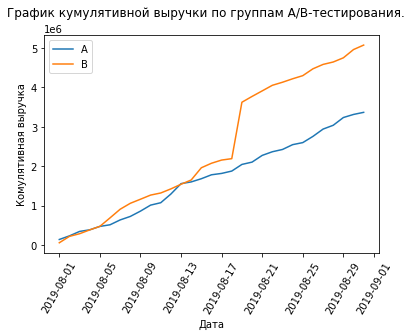

In [36]:
#import matplotlib.pyplot as plt

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')

plt.suptitle('График кумулятивной выручки по группам A/B-тестирования.') #применил для того что бы получить отступ от графика в одну строку
plt.xlabel('Дата')
plt.ylabel('Комулятивная выручка')
plt.xticks(rotation=60)
plt.legend()

plt.show()

<div class="alert alert-info" role="alert">
<h2>Комментарий студента<a class="tocSkip"></h2>

### Новый вывод.
График выручки группы А достаточно стабильно растет. Наблюдается один незначительный скачок 13-08-2019. График группы В имеет более выраженные скачки, например - сразу после 05-08-2019 и после 13-08-2019. Так же наблюдается один большой скачок после 17-08-2019. Такие скачки могут говорить о том, что в этих точках резко вырасло число заказов или о наличии в этих точках очень дорогих заказов.
    </div>

График выручки группы А имеет незначительные скачки в середине срока исследования и ближе к концу. График группы В имеет сильный скачок. Такие скачки могут говорить о том, что в этих точках резко вырасло число заказов или о наличии в этих точках очень дорогих заказов.

### 2.5 Построим график кумулятивного среднего чека по группам. 

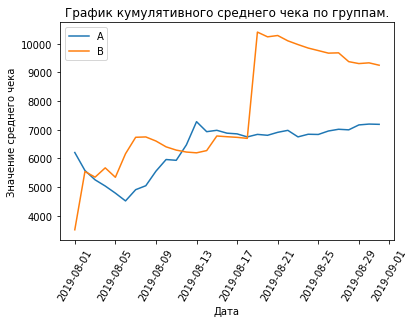

In [37]:
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')

plt.title('График кумулятивного среднего чека по группам.')
plt.xlabel('Дата')
plt.ylabel('Значение среднего чека')
plt.xticks(rotation=60)
plt.legend()

plt.show()

Средний чек имеет большое колличество скачков, что по группе А, что по группе В. Так же присутствует самый большой скачок после 17-08-2019 по группе В, который наблюдался в графике по выручке. Это все говорит о наличии крупных заказов в данных.

### 2.6 Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

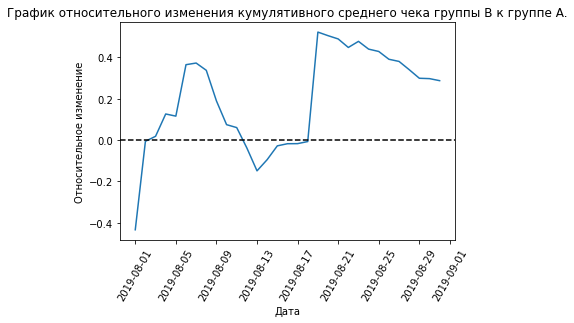

In [38]:
# собираем данные в одном датафрейме
merged_cumulative_revenue = cumulative_revenue_a.merge(cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])/(merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A.')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение')
plt.xticks(rotation=60)
#plt.legend()

plt.show()

На графике видны резкие скачки, это так же может говорить о наличии выбросов в данных.

### 2.7 Построим график кумулятивной конверсии по группам.

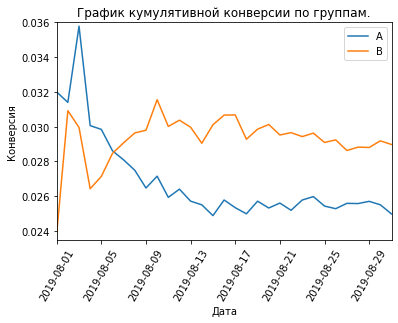

In [39]:
# считаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# отделяем данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

# строим графики
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.legend()

date_max = cumulative_data['date'].max()
date_min = cumulative_data['date'].min()

# задаем масштаб осей
plt.axis([date_min, date_max, 0.0235, 0.036])

plt.title('График кумулятивной конверсии по группам.')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.xticks(rotation=60)
plt.legend()

plt.show()

#print(date_min, date_max)

График получился не симметричным. Возмозно на это влияют выбросы в данных, которые создают "шумы". Конверсия группы В больше. Так же можно Заметить, что ближе к концу теста конверсия "сглаживается".

### 2.8 Построим график относительного изменения кумулятивной конверсии группы B к группе A.

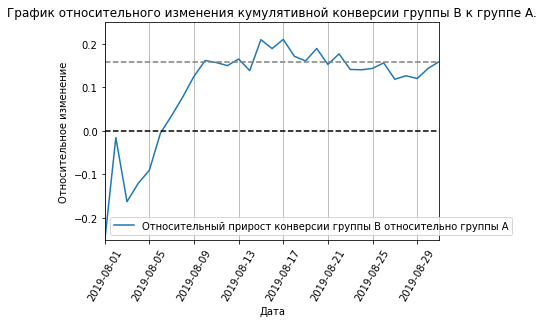

In [40]:
merged_cumulative_conversions = cumulative_data_a[['date','conversion']].merge(cumulative_data_b[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
merged_cumulative_conversions.columns = ['date', 'conversion_a', 'conversion_b']
plt.plot(merged_cumulative_conversions['date'], merged_cumulative_conversions['conversion_b']/merged_cumulative_conversions['conversion_a']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.158, color='grey', linestyle='--')
plt.axis([date_min, date_max, -0.25, 0.25])

plt.title('График относительного изменения кумулятивной конверсии группы B к группе A.')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение')
plt.xticks(rotation=60)
plt.legend()
#plt.grid()
plt.grid(axis='x')
plt.show()

### 2.9 Построим точечный график количества заказов по пользователям.

In [41]:
#data.head()

In [42]:
# получим таблицу с общим количеством заказов на одного уникального пользователя
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

orders_by_users.columns = ['visitor_id', 'orders']

orders_by_users.sort_values(by='orders', ascending=False, ignore_index=True).head()

,visitor_id,orders
0,3967698036,3
1,249864742,3
2,2108163459,3
3,2988190573,3
4,3908431265,3


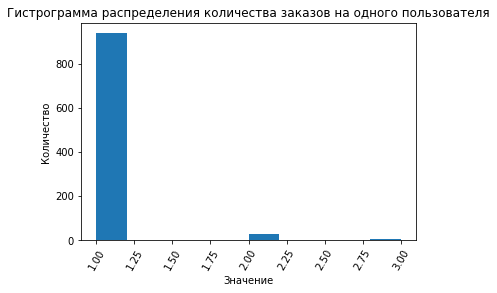

In [43]:
# Построим гистрограмму распределения количества заказов на одного пользователя.

plt.hist(orders_by_users['orders'])
plt.title('Гистрограмма распределения количества заказов на одного пользователя')
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.xticks(rotation=60)
#plt.legend()
#plt.grid()
#plt.grid(axis='x')
plt.show()

Большая часть покупателей заказали только один раз, но доля заказавших 2-4 раза тоже значительна. Так же есть пользователи сделавшие 11 заказов. Построим точечную диаграмму числа заказов на одного пользователя.

<div class="alert alert-info" role="alert">
<h2>Комментарий студента<a class="tocSkip"></h2>

### Новый вывод.
Большая часть покупателей заказали только один раз, но доля заказавших 2-3 раза тоже значительна. Построим точечную диаграмму числа заказов на одного пользователя.    </div>

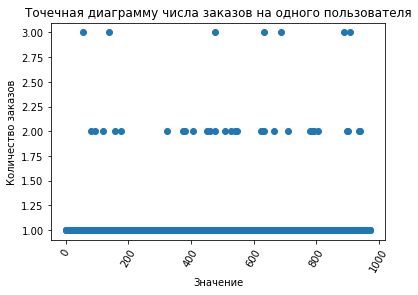

In [44]:
# построим точечную диаграмму числа заказов на одного пользователя.
x_values = pd.Series(range(0,len(orders_by_users)))

plt.scatter(x_values, orders_by_users['orders'])

plt.title('Точечная диаграмму числа заказов на одного пользователя')
plt.xlabel('Значение')
plt.ylabel('Количество заказов')
plt.xticks(rotation=60)
#plt.legend()
#plt.grid()
#plt.grid(axis='x')
plt.show()

По графику можно судить что большая часть пользователей сделала одиин заказ, далее доля пользователей сделавших 2 заказа и далее три. Доля пользователей сделавших 4 и более заказов минимальны но пока не понятно каковы эти доли в общем объеме заказов.

<div class="alert alert-info" role="alert">
<h2>Комментарий студента<a class="tocSkip"></h2>

### Новый вывод.
По графику можно судить что большая часть пользователей сделала одиин заказ, далее доля пользователей сделавших 2 заказа и далее три.
    </div>

### 2.10 Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Определим границу для определения аномальных пользователей.

In [45]:
# Определим перцентили количества заказов на одного пользователя:
print(np.percentile(orders_by_users['orders'], [95, 99]))

[1. 2.]


Выходит , что не более 5% пользователей оформляли заказ больше чем 2 раза. И не более 1% пользователей оформляли заказ больше чем 4 раза. Даже по графику можно увидеть, что пользователи оформлявшие заказ более двух раз достаточно редки. По этому считаю, что можно выбрать два заказа на одного пользователя за нижнюю границу числа заказов, и отсеять аномальных пользователей по ней.

<div class="alert alert-info" role="alert">
<h2>Комментарий студента<a class="tocSkip"></h2>

### Новый вывод.
Выходит , что не более 5% пользователей оформляли заказ больше чем 1 раз. И не более 1% пользователей оформляли заказ больше чем 2 раза. Даже по графику можно увидеть, что пользователи оформлявшие заказ два и более раз достаточно редки. По этому считаю, что можно выбрать один заказ на одного пользователя за нижнюю границу числа заказов, и отсеять аномальных пользователей по ней.
    </div>

### 2.11 Построим точечный график стоимостей заказов. 

Для начала посмотрим на гистограмму распределения стоимости заказов.

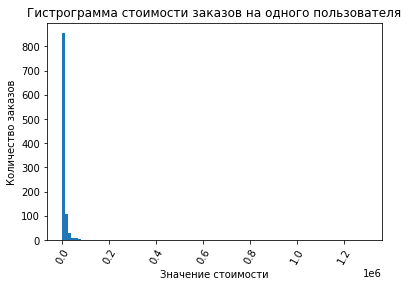

In [46]:
plt.hist(orders['revenue'], bins=100)

plt.title('Гистрограмма стоимости заказов на одного пользователя')
plt.xlabel('Значение стоимости')
plt.ylabel('Количество заказов')
plt.xticks(rotation=60)
#plt.legend()
#plt.grid()
plt.show()

Получается не очень информативно, можно лишь сказать, что большая часть заказов находится до 1Е5. 

Построим точечную диаграмму стоимости заказов на одного пользователя.

<div class="alert alert-info" role="alert">
<h2>Комментарий студента<a class="tocSkip"></h2>

### Новый вывод.
Доработаем график увеличив количество корзин до 100. Видно что больая часть заказов стремится к минимальной цене, но наличие в данных дорогих заказов не дает рассмотреть график. Построим точечную диаграмму стоимости заказов на одного пользователя.
    </div>

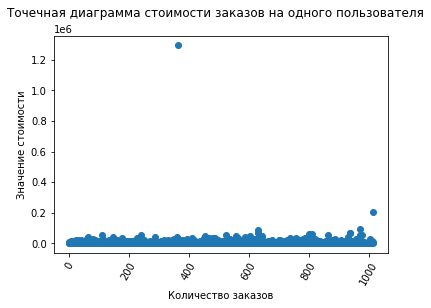

In [47]:
data = orders
x_values = pd.Series(range(0,len(data['revenue'])))
plt.scatter(x_values, data['revenue'])

plt.suptitle('Точечная диаграмма стоимости заказов на одного пользователя')
plt.xlabel('Количество заказов')
plt.ylabel('Значение стоимости')
plt.xticks(rotation=60)
#plt.legend()
#plt.grid()
#plt.grid(axis='x')
plt.show()

Вот теперь точно видно, что есть один аномально большой заказ стоимостью более 1,2Е6 и еще один не такой но все же выбивающийся из общего числа - 0,2Е6.

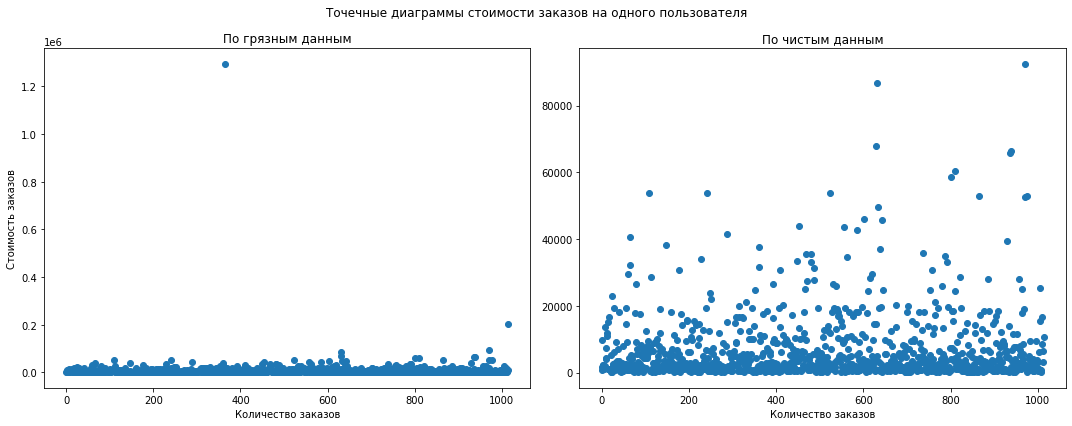

In [48]:
# Построим два графика: первый по всем данным, второй по очищенным
# для очищенных данных отфильтруем все заказы менее 200000

plt.figure(figsize=(15, 6))

ax1 = plt.subplot(1, 2, 1)
x_values = pd.Series(range(0,len(data['revenue'])))
plt.scatter(x_values, data['revenue'])
plt.xlabel('Количество заказов')
plt.ylabel('Стоимость заказов')
plt.suptitle('Точечные диаграммы стоимости заказов на одного пользователя')
plt.title('По грязным данным')

ax2 = plt.subplot(1, 2, 2)
x_values = pd.Series(range(0,len(data['revenue'][data['revenue'] < 200000])))
plt.scatter(x_values, data['revenue'][data['revenue'] < 200000])

plt.xlabel('Количество заказов')
plt.title('По чистым данным')

plt.tight_layout()
plt.show()

### 2.12 Посчитаем 95-й и 99-й перцентили стоимости заказов. Определим границу для определения аномальных заказов.

In [49]:
# Определим перцентили стоимости заказов на одного пользователя:
print(np.percentile(data['revenue'], [95,99]))

[26785. 53904.]


Не более 5% заказов дороже 28000 и не более 1% заказов дороже 58233,2. Я предполагаю, что можно отбросить заказы дороже 28000, т.к. выше приведенный график показывает хорошую кучность и близость заказов к отметке 0,05.

<div class="alert alert-info" role="alert">
<h2>Комментарий студента<a class="tocSkip"></h2>

### Новый вывод.
Не более 5% заказов дороже 26785 и не более 1% заказов дороже 53904. Я предполагаю, что можно отбросить заказы дороже 26785 т.к. выше приведенный график по чистым данным показывает, что большая часть заказов лежит ниже отметки 30000.
    </div>

### 2.13 Определим статистическую значимость различий в конверсии между группами по «сырым» данным.

#### Сформулируем гипотезы. 
<b>Нулевая</b>: различий в конверсии между группами нет. <b>Альтернативная</b>: различия в конверсии между группами есть.

In [50]:
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

visitors_a_cummulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a']

visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

visitors_b_cummulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_b_cummulative.columns = ['date', 'visitors_cummulative_a']

orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

orders_a_cummulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_a_cummulative.columns = [
    'date',
    'orders_cummulative_a',
    'revenue_cummulative_a',
]

orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

orders_b_cummulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_b_cummulative.columns = [
    'date',
    'orders_cummulative_b',
    'revenue_cummulative_b',
]

data = (
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
)

data.head()

,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a_x,visitors_cummulative_a_y
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


In [51]:
cumulative_data[cumulative_data['group'] == 'A'].head()

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,23,19,142779,719,0.031989
2,2019-08-02,A,42,36,234381,1338,0.031390
4,2019-08-03,A,66,60,346854,1845,0.035772
6,2019-08-04,A,77,71,388030,2562,0.030055
8,2019-08-05,A,99,92,474413,3318,0.029837


In [52]:
cumulative_data = cumulative_data.rename(columns={'orders': 'orders_cummulative', 'revenue': 'revenue_cummulative', 'visitors': 'visitors_cummulative'})
cumulative_data.head()

,date,group,orders_cummulative,buyers,revenue_cummulative,visitors_cummulative,conversion
0,2019-08-01,A,23,19,142779,719,0.031989
1,2019-08-01,B,17,17,59758,713,0.023843
2,2019-08-02,A,42,36,234381,1338,0.031390
3,2019-08-02,B,40,39,221801,1294,0.030912
4,2019-08-03,A,66,60,346854,1845,0.035772


### Обозначения столбцов принятые в таблицы:
- date — дата;
- orders_per_date_a — количество заказов в выбранную дату в группе A;
- revenue_per_date_a — суммарная выручка в выбранную дату в группе A;
- orders_per_date_b — количество заказов в выбранную дату в группе B;
- revenue_per_date_b — суммарная выручка в выбранную дату в группе B;
- orders_cummulative_a — суммарное число заказов до выбранной даты включительно в группе A;
- revenue_cummulative_a — суммарная выручка до выбранной даты включительно в группе A;
- orders_cummulative_b — суммарное количество заказов до выбранной даты включительно в группе B;
- revenue_cummulative_b — суммарная выручка до выбранной даты включительно в группе B;
- visitors_per_date_a — количество пользователей в выбранную дату в группе A;
- visitors_per_date_b — количество пользователей в выбранную дату в группе B;
- visitors_cummulative_a — количество пользователей до выбранной даты включительно в группе A;
- visitors_cummulative_b — количество пользователей до выбранной даты включительно в группе B.

Для определения статистической значимости различий в конверсии между группами создадим переменные <b>orders_by_users_a</b> и <b>orders_by_users_b</b> со столбцами [<b>'transaction_id', 'orders'</b>]. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [53]:
temp_t = orders.pivot_table(
    values='transaction_id', index=['group','visitor_id'], columns=None, aggfunc='count'
    ).reset_index().rename(columns={'transaction_id': 'orders'})
temp_t

,group,visitor_id,orders
0,A,11685486,1
1,A,54447517,1
2,A,66685450,1
3,A,78758296,1
4,A,85103373,1
...,...,...,...
968,B,4251115836,1
969,B,4258103007,1
970,B,4279090005,1
971,B,4281247801,1


In [55]:
orders_by_users_a = temp_t[temp_t['group'] == 'A'][['visitor_id','orders']]
orders_by_users_b = temp_t[temp_t['group'] == 'B'][['visitor_id','orders']]

In [56]:
#orders_by_users_a = (
#    orders[orders['group'] == 'A']
#    .groupby('visitor_id', as_index=False)
#    .agg({'transaction_id': pd.Series.nunique})
#)
#orders_by_users_a.columns = ['visitor_id', 'orders']

#orders_by_users_b = (
#    orders[orders['group'] == 'B']
#    .groupby('visitor_id', as_index=False)
#    .agg({'transaction_id': pd.Series.nunique})
#)
#orders_by_users_b.columns = ['visitor_id', 'orders']

sample_a = pd.concat(
    [
        orders_by_users_a['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b = pd.concat(
    [
        orders_by_users_b['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print("p-value = {0:.3f}".format(stats.mannwhitneyu(sample_a, sample_b)[1]))

print("Cтатистическая значимость различий в конверсии между группами по «сырым» данным = {0:.3f}".format(sample_b.mean() / sample_a.mean() - 1))
 

p-value = 0.011
Cтатистическая значимость различий в конверсии между группами по «сырым» данным = 0.160


p-value=1.7% что меньше 5% порогового значения. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии по сырым данным между группами нет, отвергаем. Относительный прирост группы B над группой А составил 13.8%

<div class="alert alert-info" role="alert">
<h2>Комментарий студента<a class="tocSkip"></h2>

### Новый вывод.
p-value=1.1% что меньше 5% порогового значения. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии по сырым данным между группами нет, отвергаем. Относительный прирост группы B над группой А составил 16%.
</div>

### 2.14 Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

<b>Нулевая гипотеза</b>: различий в среднем чеке между группами нет. <b>Альтернативная гипотеза</b>: различия в среднем чеке между группами есть.

Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов.
Найдём относительные различия в среднем чеке между группами:

In [57]:
print('p-value = {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Cтатистическая значимость различий в среднем чеке между группами по «сырым» данным = {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value = 0.829
Cтатистическая значимость различий в среднем чеке между группами по «сырым» данным = 0.287


p-value=72,9% значительно больше 5%. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B значительно выше среднего чека группы A.

<div class="alert alert-info" role="alert">
<h2>Комментарий студента<a class="tocSkip"></h2>

### Новый вывод.
p-value=82,9% значительно больше 5%. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B значительно выше среднего чека группы A.
    </div>

### 2.15 Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным.

#### 2.15.1 Для начала очистим данные от выбросов.

Найденные ранее 95-й и 99-й перцентили средних чеков равны 28000 и 58233,2. А 95-й и 99-й перцентили количества заказов на одного пользователя равны 2 и 4 заказа на пользователя.

Примем за аномальных пользователей тех , кто соверщил от 3 заказов и больше. Так же аномальными пользователями будут те, кто соевершил заказ дороже 28000.

Сделаем срезы пользователей с числом заказов больше 2 — users_with_many_orders и пользователей, совершивших заказы дороже 28 000 — users_with_expensive_orders. Объединим их в таблице abnormal_users.

In [58]:
users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > 2]['visitor_id'],
        orders_by_users_b[orders_by_users_b['orders'] > 2]['visitor_id'],
    ],
    axis=0,
)
users_with_expensive_orders = orders[orders['revenue'] > 20000]['visitor_id']
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values(ignore_index=True)
)
print(abnormal_users.tail(5))
print(' ')
print('Количество аномальных пользователей:',abnormal_users.shape[0], 'шт.')

71    3967698036
72    4003628586
73    4009017467
74    4133034833
75    4278982564
Name: visitor_id, dtype: int64
 
Количество аномальных пользователей: 76 шт.


Мы получили список ID аномальных пользователей, количество которых составляет - 100шт.

<div class="alert alert-info" role="alert">
<h2>Комментарий студента<a class="tocSkip"></h2>

### Новый вывод.
Мы получили список ID аномальных пользователей, количество которых составляет - 76шт.    </div>

#### 2.15.2 Сформулируем гипотезы. 
<b>Нулевая</b>: различий в конверсии между группами нет. <b>Альтернативная</b>: различия в конверсии между группами есть.

Для определения статистической значимости различий в конверсии между группами создадим переменные <b>normal_orders_by_users_a</b> и <b>normal_orders_by_users_b</b> со столбцами [<b>'transaction_id', 'orders'</b>]. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [59]:
normal_orders_by_users_a = (
    orders[(orders['group'] == 'A') & (~orders['visitor_id'].isin(abnormal_users))]
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
normal_orders_by_users_a.columns = ['visitor_id', 'orders']

normal_orders_by_users_b = (
    orders[(orders['group'] == 'B') & (~orders['visitor_id'].isin(abnormal_users))]
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
normal_orders_by_users_b.columns = ['visitor_id', 'orders']

sample_a = pd.concat(
    [
        normal_orders_by_users_a['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b = pd.concat(
    [
        normal_orders_by_users_b['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print("p-value = {0:.3f}".format(stats.mannwhitneyu(sample_a, sample_b)[1]))

print("Cтатистическая значимость различий в конверсии между группами по «очищенным» данным = {0:.3f}".format(sample_b.mean() / sample_a.mean() - 1))
 

p-value = 0.014
Cтатистическая значимость различий в конверсии между группами по «очищенным» данным = 0.181


p-value=1.8% что меньше 5% порогового значения. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Относительный прирост группы B над группой А вырос с 13.8% до 17% после очистки данных.

<div class="alert alert-info" role="alert">
<h2>Комментарий студента<a class="tocSkip"></h2>

### Новый вывод.
p-value=1.4% что меньше 5% порогового значения. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Относительный прирост группы B над группой А вырос с 13.8% до 18,1% после очистки данных.
    </div>

### 2.16 Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

#### Сформулируем гипотезы. 
<b>Нулевая</b>: различий в среднем чеке между группами нет. <b>Альтернативная</b>: различия в среднем чеке между группами есть.

In [60]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.617
-0.060


p-value с 72,9% упал до 69,8%, но все равно юольше 5%. Значит мы по прежнему не можем отвергать нулевую гипотезу и считать, что в среднем чеке есть различия. Но после очистки данным изменилосо отношение среднего чека группы В к группе А. До очистки данных, средний чек группы B был значительно выше среднего чека группы A - 25.9%, а теперь они поменялись местами. Теперь средний чек группу А больше чека группы В - 3%.

<div class="alert alert-info" role="alert">
<h2>Комментарий студента<a class="tocSkip"></h2>

### Новый вывод.
p-value с 72,9% упал до 61,7%, но все равно больше 5%. Значит мы по прежнему не можем отвергать нулевую гипотезу и считать, что в среднем чеке есть различия. Но после очистки данным изменилось отношение среднего чека группы В к группе А. До очистки данных, средний чек группы B был значительно выше среднего чека группы A - 25.9%, а теперь они поменялись местами. Теперь средний чек группу А больше чека группы В - 6%.
    </div>

# Резюмируем полученную информацию.

- Имеются статически значимые различия по среднему чеку между группами до и после фильтрации аномалий.

- График различия конверсии показывает, что результаты группы В значительно лучше чем группы А:

<div class="alert alert-info" role="alert">
<h2>Комментарий студента<a class="tocSkip"></h2>

### Новый вывод.
- p-value для среднего чека после очиски данных изменился с 72,9% до 61,7%, но все равно остался больше 5%. Значит мы по прежнему не можем отвергать нулевую гипотезу и считать, что в среднем чеке есть различия. Но после очистки данным изменилось отношение среднего чека группы В к группе А. До очистки данных, средний чек группы B был значительно выше среднего чека группы A - 25.9%, а теперь они поменялись местами. Теперь средний чек группу А больше чека группы В - 6%.
- p-value=1.4% для конверсии после очистки данных что меньше 5% - порогового значения. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Относительный прирост группы B над группой А вырос с 13.8% до 18,1% после очистки данных.
    </div>

(18109.0, 18139.0, -0.2, 0.25)

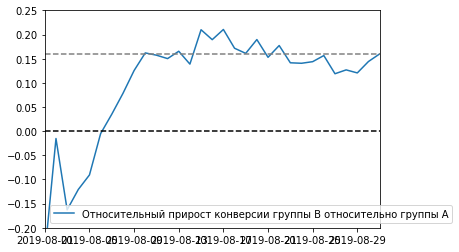

In [61]:
merged_cumulative_conversions = cumulative_data_a[['date','conversion']].merge(cumulative_data_b[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
merged_cumulative_conversions.columns = ['date', 'conversion_a', 'conversion_b']
plt.plot(merged_cumulative_conversions['date'], merged_cumulative_conversions['conversion_b']/merged_cumulative_conversions['conversion_a']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.16, color='grey', linestyle='--')
plt.axis([date_min, date_max, -0.2, 0.25])

- График относительного изменения кумулятивного среднего чека группы B к группе A говорит о том, что результаты группы В лучше на 28%:

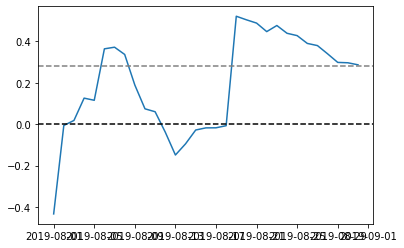

In [62]:
# собираем данные в одном датафрейме
merged_cumulative_revenue = cumulative_revenue_a.merge(cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])/(merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.28, color='grey', linestyle='--')

Исходя из выше приведенных результатов можно принять решение об остановки теста и констатировать победу группы В.